In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from keras.layers import Dropout
import datetime

#### Load the data

In [2]:
df = pd.read_csv('csna.csv')
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')

Show the data / number of rows and columns

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2013-01-02,2013-01-02,12.12,12.70,12.12,12.62,7.790152,7098900
2013-01-03,2013-01-03,12.64,12.89,12.37,12.80,7.901261,4449600
2013-01-04,2013-01-04,12.74,12.78,12.16,12.32,7.604966,8732900
2013-01-07,2013-01-07,12.37,12.49,12.04,12.26,7.567928,4316000
2013-01-08,2013-01-08,12.38,12.71,12.10,12.15,7.500027,6697500
...,...,...,...,...,...,...,...
2022-10-17,2022-10-17,12.92,13.04,12.64,12.78,12.780000,9619700
2022-10-18,2022-10-18,13.16,13.36,12.83,13.16,13.160000,9008300
2022-10-19,2022-10-19,13.12,13.14,12.74,12.87,12.870000,7449900


In [4]:
df.shape

(2437, 7)

The variable chosen to be predicted is 'Close', so the first thing that i will do is visualize the behavior of this variable throughout the years.

Text(0, 0.5, 'Close Price USD ($)')

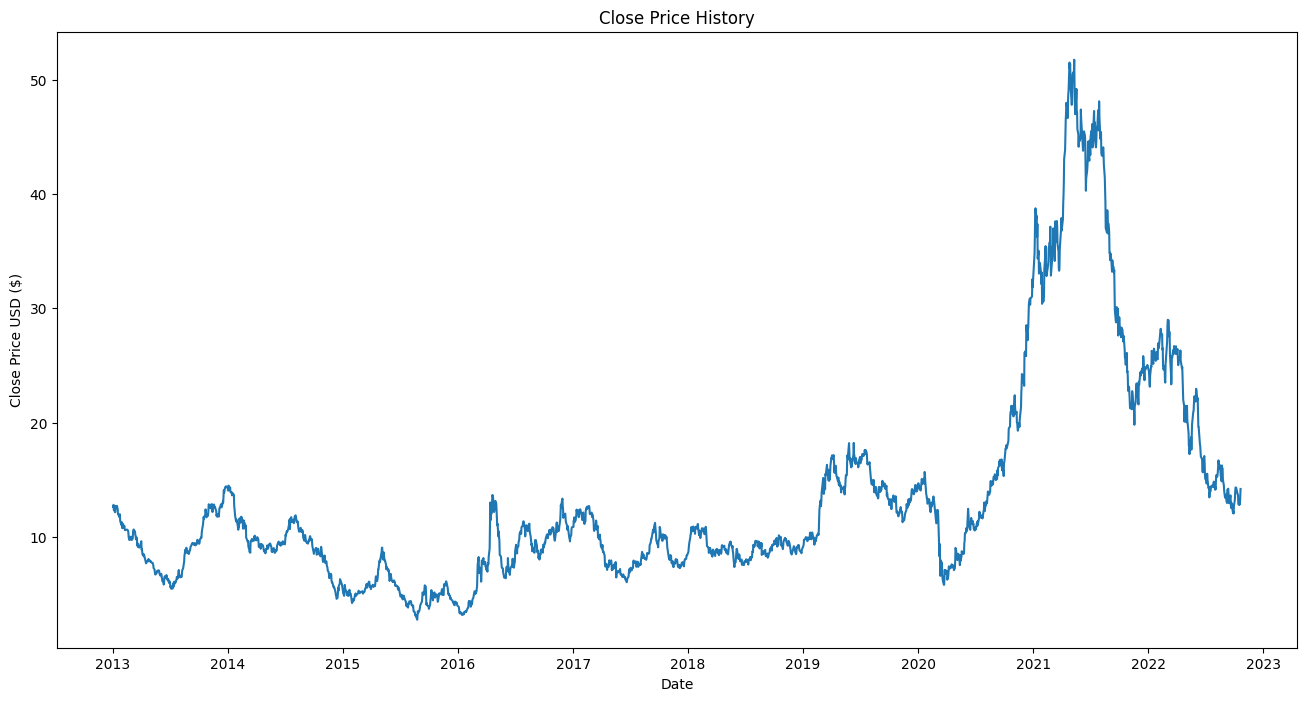

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

As i said before, the chosen variable is 'Close', so need to make a dataframe with only that variable

In [6]:
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values

The next step is scale the data. RNN and so LSTM models works better with scaled data, so this step is extremely important.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

After the steps above, i need to split the dataset in train and test to evaluate the model and compare the results.

In [8]:
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len # my train dataset, after that i removed the 20% of the last values, turns out to be 1950. So the test set that i'll use in the near future is 487.
train_data = scaled_data[0:training_data_len, :]

In [9]:
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

Convert the x_train and y_train in numpy array. After it, reshape the data. The reshape is essential for the model, because the model now is in 2d but the package asks for a data in 3d shape.

In [10]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

After this all preprocessing, it's time to make model.

In [11]:
model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=False))

# Adding the first output layer
model.add(Dense(units=25))

# Adding a second output layer
model.add(Dense(units=1))

Now is time to compile and fit the RNN model to the Training Set.

In [12]:
###Remove it later
#model.reset_states()

In [13]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, batch_size = 64, epochs = 25)

Epoch 1/25
30/30 [==============================] - 12s 78ms/step - loss: 0.0031
Epoch 2/25
30/30 [==============================] - 2s 77ms/step - loss: 4.2195e-04
Epoch 3/25
30/30 [==============================] - 2s 77ms/step - loss: 3.4765e-04
Epoch 4/25
30/30 [==============================] - 2s 83ms/step - loss: 3.1232e-04
Epoch 5/25
30/30 [==============================] - 3s 83ms/step - loss: 2.8328e-04
Epoch 6/25
30/30 [==============================] - 3s 83ms/step - loss: 2.5146e-04
Epoch 7/25
30/30 [==============================] - 2s 83ms/step - loss: 2.4320e-04
Epoch 8/25
30/30 [==============================] - 2s 83ms/step - loss: 2.2918e-04
Epoch 9/25
30/30 [==============================] - 3s 85ms/step - loss: 2.2270e-04
Epoch 10/25
30/30 [==============================] - 3s 84ms/step - loss: 2.0839e-04
Epoch 11/25
30/30 [==============================] - 3s 83ms/step - loss: 1.8686e-04
Epoch 12/25
30/30 [==============================] - 3s 85ms/step - loss: 1.9

Create the Training Set.

In [14]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

Transform in array and reshape the data.

In [15]:
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Now the next step is make the predictions in the Training Set.

In [16]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 2s 23ms/step


Getting the RSME

In [17]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.8232694600677176

C:\Users\sunse\AppData\Local\Temp\ipykernel_1560\3664363849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


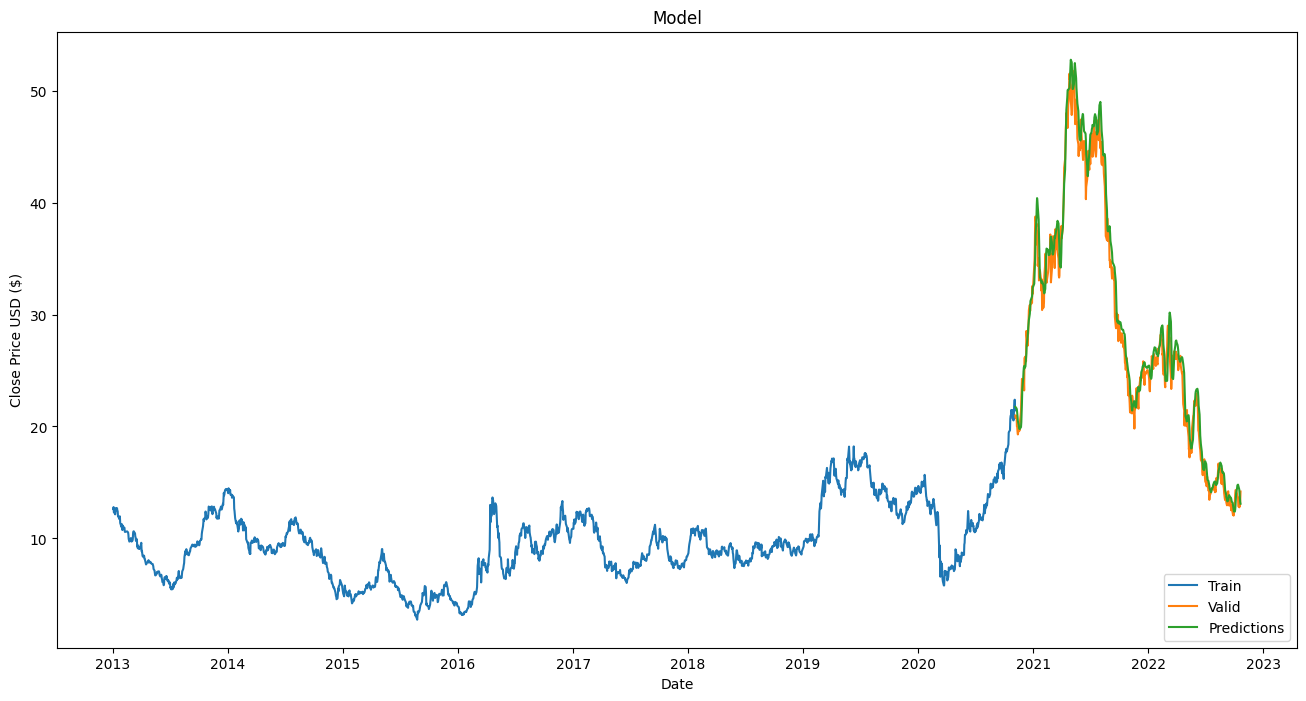

In [18]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')

Predict the next observation (day 24/10/2022) 

In [19]:
#Create a new dataframe
new_df = dataset
#Get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:]
#Scale the data
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test dataset to an numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scale prices
pred_price = model.predict(X_test)
#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 32ms/step
[[13.233744]]


The prediction of the next day gave us the value of R$13.23. The real value of this stock in 2022-10-24 was R$13.04.

Predict next 30 observations based on the past 60 days.

In [26]:
future_train_x = []
future_train_y = []
for i in range(60, len(scaled_data)):
    future_train_x.append(scaled_data[i-60:i, 0])
    future_train_y.append(scaled_data[i, 0])

future_train_x, future_train_y = np.array(future_train_x), np.array(future_train_y)
future_train_x = np.reshape(future_train_x, (future_train_x.shape[0], future_train_x.shape[1], 1))

In [48]:
model.reset_states()

In [53]:
future_model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
future_model.add(LSTM(units=50, return_sequences=True, input_shape=(future_train_x.shape[1], 1)))
future_model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
future_model.add(LSTM(units=50, return_sequences=False))

# Adding the first output layer
future_model.add(Dense(units=25))

# Adding a second output layer
future_model.add(Dense(units=1))

In [81]:
future_model.compile(optimizer='adam', loss = 'mean_squared_error')
future_model.fit(future_train_x, future_train_y, batch_size = 128, epochs = 15)

Epoch 1/15
19/19 [==============================] - 10s 119ms/step - loss: 4.1721e-04
Epoch 2/15
19/19 [==============================] - 2s 119ms/step - loss: 2.2351e-04
Epoch 3/15
19/19 [==============================] - 2s 118ms/step - loss: 2.4804e-04
Epoch 4/15
19/19 [==============================] - 2s 118ms/step - loss: 2.4076e-04
Epoch 5/15
19/19 [==============================] - 2s 120ms/step - loss: 2.4528e-04
Epoch 6/15
19/19 [==============================] - 2s 118ms/step - loss: 2.6144e-04
Epoch 7/15
19/19 [==============================] - 2s 117ms/step - loss: 2.2201e-04
Epoch 8/15
19/19 [==============================] - 2s 119ms/step - loss: 2.2992e-04
Epoch 9/15
19/19 [==============================] - 2s 125ms/step - loss: 2.3630e-04
Epoch 10/15
19/19 [==============================] - 2s 118ms/step - loss: 2.2671e-04
Epoch 11/15
19/19 [==============================] - 2s 118ms/step - loss: 2.0224e-04
Epoch 12/15
19/19 [==============================] - 3s 135ms/

In [75]:
full_future = scaled_data[len(scaled_data) - 90: , : ]

In [76]:
future_pred = []
for i in range(60, len(full_future)):
    future_pred.append(full_future[i-60:i, 0])

In [77]:
future_pred = np.array(future_pred)

future_pred = np.reshape(future_pred, (future_pred.shape[0], future_pred.shape[1], 1))

In [87]:
pred_to_future = future_model.predict(future_pred)
pred_to_future = scaler.inverse_transform(pred_to_future)

1/1 [==============================] - 0s 385ms/step


In [92]:
pred_to_future

array([[13.068999 ],
       [13.571458 ],
       [13.98786  ],
       [13.789274 ],
       [13.290058 ],
       [12.957366 ],
       [12.932064 ],
       [13.286167 ],
       [13.2313385],
       [12.82017  ],
       [12.824744 ],
       [12.812493 ],
       [12.525067 ],
       [12.22391  ],
       [12.141964 ],
       [12.048641 ],
       [12.387309 ],
       [12.916513 ],
       [13.560355 ],
       [14.101371 ],
       [14.325967 ],
       [14.350815 ],
       [14.126899 ],
       [13.880839 ],
       [13.714873 ],
       [13.20899  ],
       [12.880089 ],
       [12.977566 ],
       [12.939551 ],
       [13.188266 ]], dtype=float32)

This model, in comparison with the first one, gave the value to the next day of R$13.11, wich was more accurate than the R$13.23 before.

Text(0.5, 1.0, 'Model')

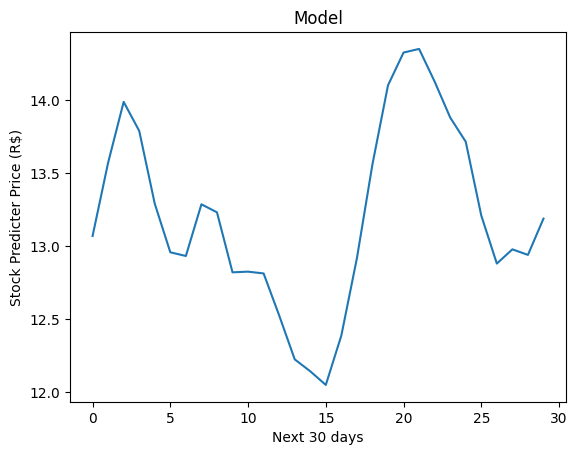

In [89]:
plt.plot(pred_to_future)
plt.xlabel('Next 30 days')
plt.ylabel('Stock Predicter Price (R$)')
plt.title('Model')

To plot the last real values with the predicted values i need to concatenate the 2 arrays.

In [90]:
concat_values = np.concatenate((dataset[-60:], pred_to_future), axis=None)

Text(0.5, 1.0, 'Model')

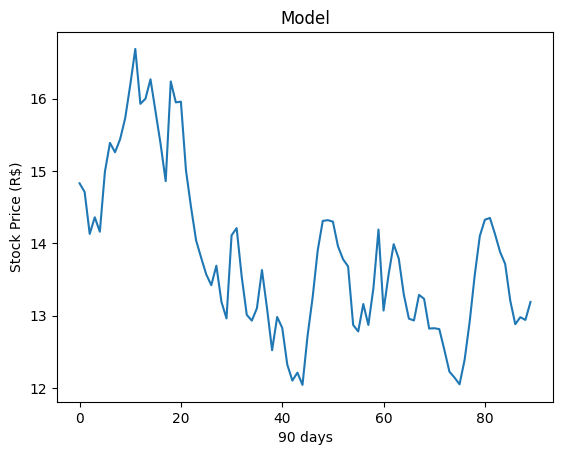

In [91]:
plt.plot(concat_values)
plt.xlabel('90 days')
plt.ylabel('Stock Price (R$)')
plt.title('Model')

The predicted values in the plot above start at day 60.